# Self Study 4


In this self study we implement and test a simple Markov network model for node prediction, and a Gibbs sampling inference (prediction) process. 

For this material there is no direct support from scikit learn, so we have to do a little more coding ourselves than before ...

For basic network functionalities we use the `networkx` package: https://networkx.github.io/documentation/stable/index.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx import read_edgelist
import random

We are using a social network consisting of 71 lawyers. A description of the network and the original data can be found here:

http://moreno.ss.uci.edu/data.html#lazega

Of the three different relationships included in the data we will only be using the 'friendship' relation. This is a directed relationship, i.e., friends(a,b) does not necessarily imply friends(b,a) according to the data.

We first construct a networkx graph from the file lazega-friends.edges. The node attributes are read from a separate file into a Pandas data frame:

In [2]:
lazega = read_edgelist('lazega-friends.edges', nodetype=int) 
node_atts = pd.read_csv("lazega-attributes.txt", sep=' ')
display(node_atts)

,nodeID,nodeStatus,nodeGender,nodeOffice,nodeSeniority,nodeAge,nodePractice,nodeLawSchool
0,1,1,1,1,31,64,1,1
1,2,1,1,1,32,62,2,1
2,3,1,1,2,13,67,1,1
3,4,1,1,1,31,59,2,3
4,5,1,1,2,31,59,1,2
...,...,...,...,...,...,...,...,...
66,67,2,2,1,1,35,1,2
67,68,2,1,1,1,26,1,3
68,69,2,2,1,1,38,1,3
69,70,2,1,1,1,31,2,2


Now we annotate the nodes in the graph with some selected attributes (later on, if you want to do more, you can consider additional attributes). 

In [3]:

for i in range(node_atts.shape[0]):
    lazega.add_node(node_atts.loc[i,'nodeID'], gender=node_atts.loc[i,'nodeGender'])
    lazega.add_node(node_atts.loc[i,'nodeID'], office=node_atts.loc[i,'nodeOffice'])
    lazega.add_node(node_atts.loc[i,'nodeID'], true_practice=node_atts.loc[i,'nodePractice'])
    if random.random() > 0.4:
        lazega.add_node(node_atts.loc[i,'nodeID'], observed_practice=node_atts.loc[i,'nodePractice'])
    else:
        lazega.add_node(node_atts.loc[i,'nodeID'], observed_practice=np.nan)

The 'practice' attribute is going to be our class label that we want to predict. Therfore, we pretend that this attribute is not observed for some randomly selected nodes. We do this by adding a new attribute 'observed_practice' which has either the true practice value, or 'nan' for unobserved.

In [4]:
random.seed(5)
for i in range(node_atts.shape[0]):
    if random.random() > 0.4:
        lazega.add_node(node_atts.loc[i,'nodeID'], observed_practice=node_atts.loc[i,'nodePractice'])
    else:
        lazega.add_node(node_atts.loc[i,'nodeID'], observed_practice=np.nan)

The following is a utility function for retrieving a plain numpy array containing the values of a selected attribute for all nodes. 

In [7]:
def get_att_array(G,att_name):
    ret_array=np.zeros(nx.number_of_nodes(G))
    for i,n in enumerate(G.nodes()):
        ret_array[i]=G.nodes[n][att_name]
    return(ret_array)

# Example: the gender attribute:
print(get_att_array(lazega,'gender'))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1.
 1. 2. 2. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 2. 1. 2. 2. 1. 2.
 1. 1. 1. 1. 2. 1. 2. 1. 1. 1. 1. 2. 1. 2. 1. 1. 2. 1. 2. 1. 2. 2. 1.]


**Beware:** lazega.nodes[n] returns nodes according to their key (= nodeID) value, which are the integers 1..71, whereas the arrays returned by get_att_array are indexed 0..70. 

We can draw the network with node coloring according to a selected attribute as follows:

/home/jaeger/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


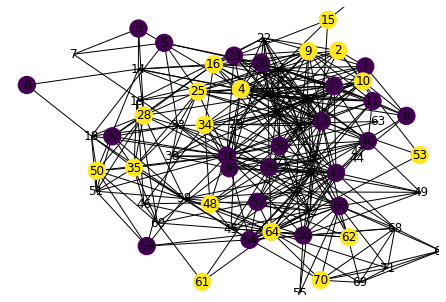

In [8]:
nx.draw_kamada_kawai(lazega,with_labels=True,node_color=get_att_array(lazega,'observed_practice'))

We now want to predict the missing 'practice' labels using Gibbs sampling on a Markov network model. We will first need to initialize values for the unobserved attributes. 

**Task 1:** complete the following function:

In [9]:
def init_practice():
    # This function should add an additional attribute predicted_practice.
    # The value of predicted_practices is the same as observed_practice when observed_practice != nan. Otherwise, 
    # predicted_practice is a randomly sampled 'practice' value.

SyntaxError: unexpected EOF while parsing (<ipython-input-9-a834c750ae7e>, line 4)

We next define some potential functions. Mostly we will be using node or edge potentials, i.e., potential functions that
depend only on the attributes of a single node, or on the attributes of two nodes (connected by an edge). 

Instead of defining the potential function directly, it is more convenient to first define the log of the potential function. Then, instead of taking a big product (cf. slide 7), one can first take the sum of relevant potentials, and apply an exponential at the end. E.g., the log of the homophily potential (slide 21) is w in the case A_i=A_j, and 0 otherwise. Also, all real numbers are then permissible return values, without the non-negativity condition.

The following are examples of a simple node (log-)potential and an "ising-style" homophily potential. Both potential functions depend on numerical parameters w1,w2. You may start with using these two log-potentials only, and later define additional potential functions.

In [10]:
def n_log_potential_1(n,w1,w2):
    if n['gender'] == 1: return w1
    else: return w2

In [11]:
def n_log_potential_2(n1,n2,w1,w2):
    if n1['predicted_practice']==n2['predicted_practice']: return w1
    else: return w2

In [12]:
print(n_log_potential_1(lazega.nodes[5],-1,1))
print(n_log_potential_2(lazega.nodes[5],lazega.nodes[6],-2,3))

-1


KeyError: 'predicted_practice'

**Task 2:** Write a Gibbs-sampling function for re-sampling the 'predicted_practice' attribute value for a node *n*. At this point we need not worry whether for *n* the actual 'practice' value is known or not.

In [12]:
def gibbs_sample(n):
    # Iterate over all log-potential functions you want to use
    # For node potentials, evaluate the potential for the given node n
    # For edge potentials, evaluate the potential for all pairs (n,n') where n' is a neighbor in the 'friendship' graph.
    #
    # Since the friendship graph is directed, there are three possibilities of how to do this precisely:
    #        - consider all n' where friends(n,n')
    #        - consider all n' where friends(n',n)
    #        - consider both cases of n'
    # 
    # The method nx.all_neighbors(lazega,n) will return an iterator over both types of neighbors of n, so the third
    # option is the most convenient to use (and maybe also the most sensible)
    #
    # Sum the values of all the potential functions, and take the exponential.
    # This has to be done for both possible values of the 'predicted_practice' value for n
    #
    # You will probably need to add arguments to the gibbs_sample method for the numerical parameters of 
    # the potential functions that you are using.
    # 
    # Calculate the probability for predicted_practice(n) according to the quotient shown on slide 12 (see also slide 23)
    #
    # Set the new value of predicted_practice(n) randomly according to the probabilities you have just computed. 

IndentationError: expected an indented block (<ipython-input-12-a573d62bd575>, line 22)

Once the resampling of the predicted_practice attribute for a single node is in place, the rest is quite straightforward: 

**Task 3**: Write a function that performs one round of Gibbs sampling, i.e., re-samples the predicted values for all nodes for which the class attribute is unknown.

In [13]:
def gibbs_one_round(G):
    # Iterate over all nodes n in G for which observed_practice == nan, and re-sample its predicted_practice value

IndentationError: expected an indented block (<ipython-input-13-9be0a674d8a3>, line 2)

Now we can put everything together to use our model to predict the 'practice' attribute. 

**Task 4**: write code for doing the following:

In [14]:
# Initialize with init_att
#
# Perform a number of gibbs_one_round(lazega) sampling steps
#
# (Maybe after a certain number of burn-in iterations): keep count of how often the predicted_practice value of nodes 
# with observed_practice == nan is in the two states 1 or 2.
# 
# Predict the unobserved practice values as the more probably state in the Gibbs sample
#
# Compare your predicted values against the true values

Now that things are up and running, we can explore some of the properties of the model and the Gibbs sampling procedure: 

**Task 5**: 

<ul>
<li> Perform the Gibbs-prediction procedure several times and explore how stable the prediction results are. Apart from the final categorical prediction, you can also consider the actual frequencies of the two 'predicted_practice" states in your samples</li>
    <li> Try different settings of the parameter values of the potential functions. Can you find a relationship between the parameter values, and the stability of the Gibbs sampling? </li>
    <li> Also try different parameter settings in order to optimize prediction accuracy. In a real application, one would learn the parameter values by likelihood optimization based on the labeled training nodes. This is outside the scope of what we can do here, so let's do a simple grid search over parameter values instead (ugly!) and evaluate by checking accuracy using the known actual labels for the test nodes (knowing that -- in principle -- this is forbidden!).
    </ul>